In [1]:
# Standard Imports
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial import distance

# Pull in data, exclude non-audio features in one dataframe
df = pd.read_csv('..//Data//artist_static_data.csv')
df = df.set_index('artist')
df_audio = df.loc[:, ~df.columns.isin(['av_time_btwn_release', 'total_albums', 
                                       'track_per_album', 'classic'])]

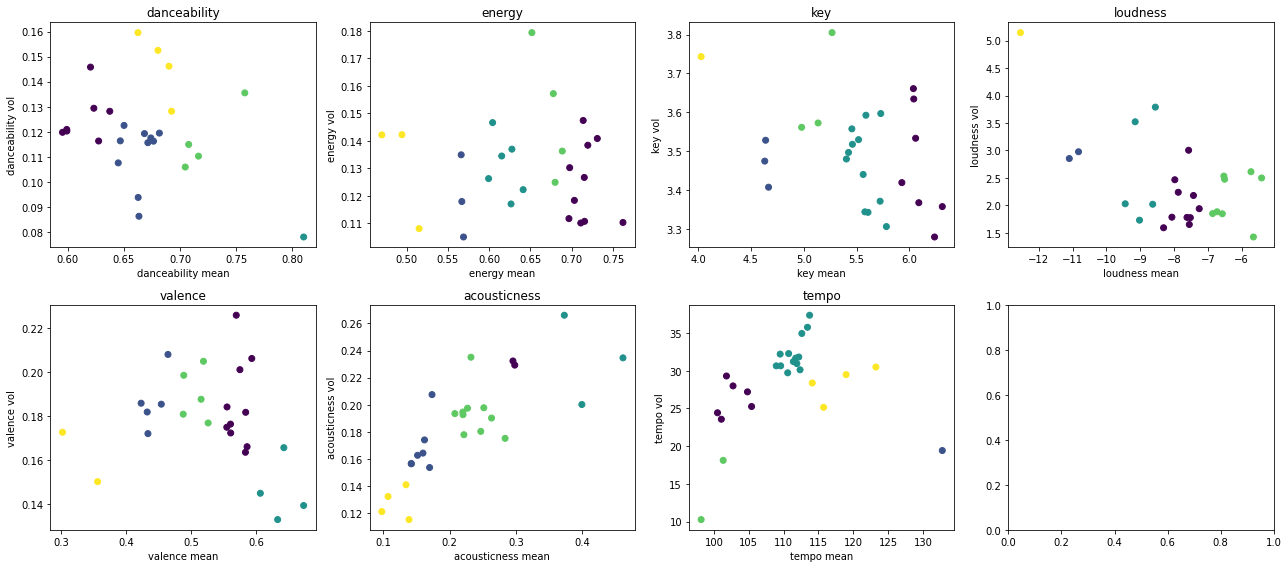

In [2]:
# Look at potential clusters along various features
fig, axs = plt.subplots(2, 4, figsize = (18, 8))
axs = axs.ravel()
vars_interest = ['danceability', 'energy', 'key', 'loudness', 'valence', 'acousticness', 'tempo']
#clusters = [4, 5]
labels_dict = {}
for ii in range(len(vars_interest)):
    sub_vars = df.loc[:, (f'{vars_interest[ii]} mean', f'{vars_interest[ii]} vol')]
    model = KMeans(n_clusters = 5, random_state = 0).fit(sub_vars)
    
    # Scatter plot with artist names as labels
    x = sub_vars.loc[:, f'{vars_interest[ii]} mean']
    y = sub_vars.loc[:, f'{vars_interest[ii]} vol']
    axs[ii].scatter(x = x, y = y, c = model.labels_)
    axs[ii].set_title(vars_interest[ii])
    axs[ii].set_xlabel(f'{vars_interest[ii]} mean')
    axs[ii].set_ylabel(f'{vars_interest[ii]} vol')
    
plt.tight_layout()
    

Text(0.5, 1.0, 'Variance % Exlained by PCA on Vol Features')

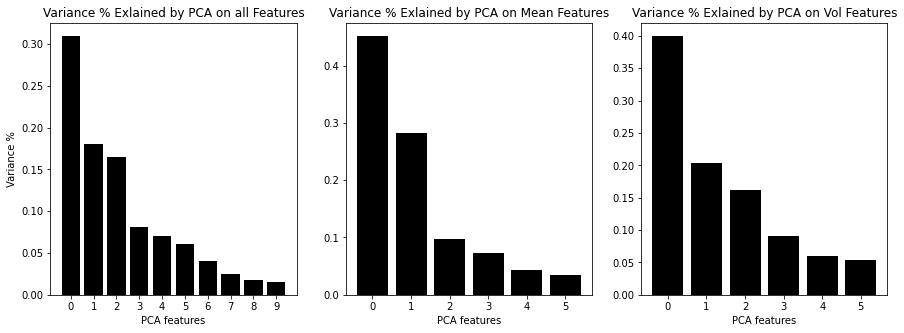

In [3]:
# PCA for all features
mean_vars = [var + ' mean' for var in  vars_interest]
vol_vars = [var + ' vol' for var in  vars_interest]
x = df.loc[:, mean_vars + vol_vars]
X = StandardScaler().fit_transform(x)
pca = PCA(n_components=10)
pcs = pca.fit_transform(X)
pc_df = pd.DataFrame(data = pcs, index = x.index)

# PCA just for mean of features
x_mean = df.loc[:, mean_vars]
X_mean = StandardScaler().fit_transform(x_mean)
pca_mean = PCA(n_components=6)
pcs_mean = pca_mean.fit_transform(X_mean)
pc_mean = pd.DataFrame(data = pcs_mean, index = x.index)

# PCA for vol of features
x_vol = df.loc[:, vol_vars]
X_vol = StandardScaler().fit_transform(x_vol)
pca_vol = PCA(n_components=6)
pcs_vol = pca_vol.fit_transform(X_vol)
pc_vol = pd.DataFrame(data = pcs_vol, index = x.index)


#Initializing Plot
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

# First 3 Principal components explain most of the variation in all the features
features = range(pca.n_components_)
axs[0].bar(features, pca.explained_variance_ratio_, color='black')
axs[0].set_xlabel('PCA features')
axs[0].set_ylabel('Variance %')
axs[0].set_xticks(features)
axs[0].set_title('Variance % Exlained by PCA on all Features')

# First 2 Principal components explain most of the variation in the mean features
features = range(pca_mean.n_components_)
axs[1].bar(features, pca_mean.explained_variance_ratio_, color='black')
axs[1].set_xlabel('PCA features')
#axs[1].set_ylabel('Variance %')
axs[1].set_xticks(features)
axs[1].set_title('Variance % Exlained by PCA on Mean Features')

# First 3 Principal components explain most of the variation in the mean features
features = range(pca_vol.n_components_)
axs[2].bar(features, pca_vol.explained_variance_ratio_, color='black')
axs[2].set_xlabel('PCA features')
#axs[2].set_ylabel('Variance %')
axs[2].set_xticks(features)
axs[2].set_title('Variance % Exlained by PCA on Vol Features')

In [4]:
# Initialize matrix to store intra-artist distance (calculated in reduced feature space)
art_dist = pd.DataFrame(index = pc_mean.index, columns = pc_mean.index)

# Calculate 2D distance between artists using PCA reduction of Mean Features
for ii in range(len(art_dist.index)):
    for jj in range(len(art_dist.index)):
        art1 = pc_mean.iloc[ii, [0, 1]]
        art2 = pc_mean.iloc[jj, [0, 1]]
        dist = distance.euclidean(art1, art2)
        art_dist.iloc[ii, jj] = dist
        
# Calculate N closest artists to each other
N = 6
close_artists = dict()
for ii in range(len(art_dist.index)):
    
    artist = art_dist.index[ii]
    artists = art_dist.iloc[ii, ].sort_values().head(N+1)[1:].index
    dist = art_dist.iloc[ii, ].sort_values().head(N+1)[1:].values
    close_artists_series = pd.Series(index = artists, data = dist)
    close_artists[artist] = close_artists_series
    

Text(0.5, 1.0, 'Most similar artists to Kanye West')

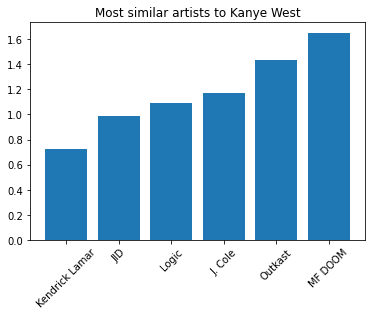

In [5]:
# Plot of most similar artists
all_artists = art_dist.index.tolist()
#fig, axs = plt.subplots(5, 2, figsize = (15, 10))
#axs = axs.ravel()
#for ii in range(len(axs)):
#    axs[ii].bar(close_artists[all_artists[ii]].index, close_artists[all_artists[ii]].values)

artist = 'Kanye West'
plt.bar(close_artists[artist].index, close_artists[artist].values)
plt.xticks(rotation = 45)
plt.title(f'Most similar artists to {artist}')

Text(0.5, 1.0, 'Distribution of Intra-Artist Distances')

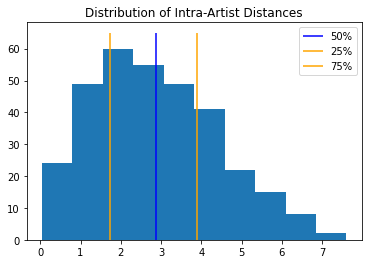

In [6]:
# Who seems to be the most influential artist? - Establish a cutoff, for a kind of network diagram,
# whoever has the most connections is the most influential - might be Ye?

# Distribution of distance scores between artists

# Get non redundant distances between artists
art_dist_mat = np.matrix(art_dist)
idx = np.triu_indices(26, k = 1)
all_art_mat = art_dist_mat[idx]

# Distribution of non-redundant distances between artists
all_art_dist = pd.Series(np.ndarray.flatten(all_art_mat).tolist()[0])
dist_stats = all_art_dist.describe()
#all_art_dist = np.array(all_art_dist)
#print(dist_stats)

# Plot distribution of distances
plt.hist(all_art_dist)
plt.vlines(x = dist_stats.loc['mean'], ymin = 0, ymax = 65, label = '50%', color = 'blue')
plt.vlines(x = dist_stats.loc['25%'],  ymin = 0, ymax = 65, label = '25%', color = 'orange')
plt.vlines(x = dist_stats.loc['75%'],  ymin = 0, ymax = 65, label = '75%', color = 'orange')
plt.legend()
plt.title('Distribution of Intra-Artist Distances')

In [23]:
# Calculate number of connections per artist
art_fin = dict()
art_cons = pd.DataFrame(columns = ['artist', 'cons'])
for ii in range(len(art_dist.index.tolist())):
    
    artist = art_dist.index[ii]
    artists = pd.DataFrame(art_dist.iloc[ii, :].copy())
    similar_artists = artists[(artists[artist] < 1.75) & (artists.index != artist)].index.tolist()
    art_fin[artist] = similar_artists
    art_cons.loc[ii, 'artist'] = artist
    art_cons.loc[ii, 'cons'] = len(similar_artists)

# Sort first by number of connections, then alphabetical order    
art_cons = art_cons.sort_values(['cons', 'artist'], ascending = [False, False])
sorted_arts = art_cons.loc[:, 'artist']
sort_fin = {artist: art_fin[artist] for artist in sorted_arts}

In [24]:

# Remove redudant connections, but preserve order for chart -> close but no cigar
art_fin_red = dict()
sorted_df = art_dist.loc[sorted_arts, sorted_arts].copy()
art_cons_red = pd.DataFrame(columns = ['artist', 'cons'])
for ii in range(len(sorted_df.columns)):

    artist = sorted_df.columns[ii]
    print(ii, artist)
    artists = pd.DataFrame(sorted_df.iloc[ii:, ii].copy())
    similar_artists = artists[(artists[artist] < 1.75) & (artists.index != artist)].index.tolist()
    art_fin_red[artist] = similar_artists
    art_cons_red.loc[ii, 'artist'] = artist
    art_cons_red.loc[ii, 'cons'] = len(similar_artists)

sort_fin_red = {artist: art_fin_red[artist] for artist in sorted_arts}

0 Wu-Tang Clan
1 Mobb Deep
2 Cypress Hill
3 The Notorious B.I.G.
4 Snoop Dog
5 Nas
6 MF DOOM
7 Tupac
8 Outkast
9 Mos Def
10 Dr. Dre
11 Jay-Z
12 JID
13 Kanye West
14 J. Cole
15 Kendrick Lamar
16 Naughty by Nature
17 BROCKHAMPTON
18 Logic
19 Smino
20 SZA
21 De La Soul
22 Common
23 A Tribe Called Quest
24 Travis Scott
25 Lauryn Hill


In [27]:
# Check for redundant connections
print(sum([len(value) for value in sort_fin_red.values()]))
print(sum([len(value) for value in sort_fin.values()]))
#[(artist, len(value)) for (artist, value) in sort_fin_red.items()]

# Save to dictionary to convert to JSON
np.save('../Data/artist_links.npy', sort_fin_red)

83
166
